In [ ]:
# Last updated: GHS
# email: gabrielsarch@gmail.com
#
# Last edited: 4/25/2020

In [1]:
# This file trains the Convolutional Neural Network
## Uses siren, car, and background noises (split into 3-second chunks)


In [3]:
import math

RATE = 22050 #Hz - sample rate of training files

# paths to numpy array files
# These files contain numpy arrays in format (nSoundBytes x nSamples) 
# nSamples is usually = RATE*seconds
# see generateTrainingData
sirenFile = r'C:\Users\Gabe\Documents\SeniorDesign\Data\Senior Design data training\sirenNoise.npy'
backFile = r'C:\Users\Gabe\Documents\SeniorDesign\Data\Senior Design data training\backNoise.npy'
carFile = r'C:\Users\Gabe\Documents\SeniorDesign\Data\Senior Design data training\carNoise.npy'

# Where to save CNN Model WEIGHTS (not full architecture)
saveModel = 'C:/Users/Gabe/Documents/SeniorDesign/CNNModels/weights.best.basic_cnn.hdf5'

# Where to save model architecture + weights
modelSave = 'C:/Users/Gabe/Documents/Driver-Alert/Models/siren_detector_V2.h5'

# Parameters for generateData
num_samples = 999 # number of samples used for training from each array
num_samp_noise = math.floor(num_samples/3)*4 # need more noise samples than siren samples


In [4]:
# Load in numpy arrays containing data & splits data up into training and validation sets (use validation for ROC curves)

import numpy as np

sirenNoise = np.load(sirenFile)
backNoise = np.load(backFile)
carNoise = np.load(carFile)

print('Array shapes before:')
print(sirenNoise.shape)
print(backNoise.shape)
print(carNoise.shape)
print(' ')

percentHeldOut = 0.1

perm = np.random.permutation(len(sirenNoise))[0:round(percentHeldOut*sirenNoise.shape[0])]
sirenNoiseVal = sirenNoise[perm]
sirenNoise = np.delete(sirenNoise, perm, axis=0)

perm = np.random.permutation(len(backNoise))[0:round(percentHeldOut*backNoise.shape[0])]
backNoiseVal = backNoise[perm]
backNoise = np.delete(backNoise, perm, axis=0)

perm = np.random.permutation(len(carNoise))[0:round(percentHeldOut*carNoise.shape[0])]
carNoiseVal = carNoise[perm]
carNoise = np.delete(carNoise, perm, axis=0)

print('Array shape after (valid, train):')
print(sirenNoiseVal.shape)
print(sirenNoise.shape)
print(backNoiseVal.shape)
print(backNoise.shape)
print(carNoiseVal.shape)
print(carNoise.shape)

Array shapes before:
(1839, 66150)
(6566, 66150)
(613, 66150)
 
Array shape after (valid, train):
(184, 66150)
(1655, 66150)
(657, 66150)
(5909, 66150)
(61, 66150)
(552, 66150)


In [13]:
x = True
isinstance(x,int) #or x==False
if not isinstance(x, bool):
    print('Hello')
type(x)
#raise TypeError('HI')

bool

In [14]:
from scipy import signal
import pandas as pd
import os
import librosa

sos = signal.butter(5, [50, 5000], 'bandpass', fs=RATE, output='sos')

def get_mfccs(audio):
   
    try:
        audio = 2*((audio-min(audio))/(max(audio)-min(audio)))-1

        #Filter
        audio = signal.sosfilt(sos, audio)
        
        mfccs = librosa.feature.mfcc(y=audio, sr=RATE, n_mfcc=40)

    except Exception as e:
            print("Error encountered for a file")
            return None

    return mfccs

In [19]:
## Fit #1

from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
import math
import random
from sklearn.model_selection import train_test_split 



def generateData(carNoise, backNoise, sirenNoise, uniformSNR=False):
# This function 
# 1) combines siren and noise data to create 2 groups: siren present group, siren not present group
# siren group: siren + car, siren + environment, siren + car + environmental (4 signal to noise ratios for each group)
# no siren group: car, environment, car + environmental 
# Then
# 2) Normalizes the audio and extracts

# Inputs:
# 1-3) car noises, background noises, siren noises (np array, nSoundBytes x nSamples)
# 4) uniformSNR - if input = false (default) training data will consist of multiple SNRs (-5, 0, 5, 10 dB SNR)
#               - if input = True will deafult to SNR of 0 dB
#               - if input = Db (integer) will do SNR of that dB
    Db5gain = 1.778279 # gain for 5dB increase

    if isinstance(uniformSNR,int):
       # if uniformSNR==True:
        #    uniformSNR = 0.0001 # Set SNR to 0 if True
        if not isinstance(uniformSNR, bool):
            if uniformSNR > 0:
                DbMult = uniformSNR/5 # Excludes if uniformSNR = False
            elif uniformSNR < 0:
                DbMult = 1/(-uniformSNR/5)
                Db5gain = 1/Db5gain
            elif uniformSNR == 0:
                uniformSNR = True
            else:
                raise TypeError('Wrong uniformSNR input')
    else:
        raise TypeError('Wrong uniformSNR input')

    start = datetime.now()

    # get desired number of samples from each array
    if len(carNoise) < num_samp_noise:
        extra = num_samp_noise - len(carNoise)
        perm = np.random.permutation(len(carNoise))
        carX = np.concatenate((carNoise[perm], carNoise[perm[0:extra]]))
        if len(carX) < num_samp_noise:
            extra = num_samp_noise - len(carX)
            perm = np.random.permutation(len(carX))
            carX = np.concatenate((carX[perm], carX[perm[0:extra]]))
    else:
        perm = np.random.permutation(len(carNoise))[0:num_samp_noise]
        carX = carNoise[perm]

    if len(backNoise) < num_samp_noise:
        extra = num_samp_noise - len(backNoise)
        perm = np.random.permutation(len(backNoise))
        envX = np.concatenate((backNoise[perm], backNoise[perm[0:extra]]))
    else:
        perm = np.random.permutation(len(backNoise))[0:num_samp_noise]
        envX = backNoise[perm]

    if len(sirenNoise) < num_samples:
        extra = num_samples - len(sirenNoise)
        perm = np.random.permutation(len(sirenNoise))
        sirenX = np.concatenate((sirenNoise[perm], sirenNoise[perm[0:extra]]))
    else:
        perm = np.random.permutation(len(sirenNoise))[0:num_samples]
        sirenX = sirenNoise[perm]


    # Add gain to background noise
    splitback1 = math.floor(num_samples/3)
    
    if uniformSNR == False:
        
        print("Mixing various SNRs")

        carX[0:splitback1] = carX[0:splitback1]*(1/(2*Db5gain))
        carX[splitback1:splitback1*2] = carX[splitback1:splitback1*2]*(1/Db5gain)
        carX[splitback1*2:splitback1*3] = carX[splitback1*2:splitback1*3]
        carX[splitback1*3:] = carX[splitback1*3:]*Db5gain

        envX[0:splitback1] = envX[0:splitback1]*(1/(2*Db5gain))
        envX[splitback1:splitback1*2] = envX[splitback1:splitback1*2]*(1/Db5gain)
        envX[splitback1*2:splitback1*3] = envX[splitback1*2:splitback1*3]
        envX[splitback1*3:] = envX[splitback1*3:]*Db5gain

        #sirenX[0:splitback1] = sirenX[0:splitback1]
        #sirenX[splitback1:splitback1*2] = envX[splitback1:splitback1*2]*Db5gain
        #sirenX[splitback1*2:splitback1*3] = envX[splitback1*2:splitback1*3]*Db5gain*2
        #sirenX[splitback1*3:] = sirenX[splitback1*3:]*Db5gain*3
        
    elif uniformSNR == True: # SNR of 0 dB
        print("SNR of 0 dB")
        sirenX = sirenX*1
    
    else:    
        print("Uniform SNR with SNR = ", uniformSNR)
        sirenX = sirenX*Db5gain*DbMult

    sirencar = sirenX[0:splitback1]+carX[0:splitback1]
    sirenenv = sirenX[splitback1:splitback1*2]+envX[0:splitback1]
    sirencarenv = sirenX[splitback1*2:splitback1*3]+carX[splitback1:splitback1*2]*0.5+envX[splitback1:splitback1*2]*0.5

    sirenSet = np.concatenate((sirencar, sirenenv, sirencarenv))
    noiseSet = np.concatenate((carX[splitback1*2:splitback1*3], envX[splitback1*2:splitback1*3], carX[splitback1*3:splitback1*4]+envX[splitback1*3:splitback1*4]))            

    print('Finished scrambling data set')
    print('Extracting MFCCs...')

    mfccSiren = []
    for i in range(0,len(sirenSet)):
        cur_audio = sirenSet[i]
        #cur_audio = 2*((cur_audio-min(cur_audio))/(max(cur_audio)-min(cur_audio)))-1
        mfcc = get_mfccs(cur_audio)
        mfccSiren.append(mfcc)
        sirenSet[i] = cur_audio

    mfccNoise = []
    for i in range(0,len(noiseSet)):
        cur_audio = noiseSet[i]
        #cur_audio = 2*((cur_audio-min(cur_audio))/(max(cur_audio)-min(cur_audio)))-1
        mfcc = get_mfccs(cur_audio)
        mfccNoise.append(mfcc)
        noiseSet[i] = cur_audio
    
    # Create labels for the data
    sirenLabels = ['siren']*len(mfccSiren) 
    noiseLabels = ['noise']*len(mfccNoise)

    # Comibine MFCCs and labels 
    featureSiren = list(zip(mfccSiren, sirenLabels))
    featureNoise = list(zip(mfccNoise, noiseLabels))
    features = featureSiren + featureNoise
    random.shuffle(features)
    
    # Convert to Panda dataframe
    featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

    from sklearn.preprocessing import LabelEncoder
    from keras.utils import to_categorical

    # Convert features and corresponding classification labels into numpy arrays
    X = np.array(featuresdf.feature.tolist())
    y = np.array(featuresdf.class_label.tolist())

    # Encode the classification labels
    le = LabelEncoder()
    yy = to_categorical(le.fit_transform(y)) 

    duration = datetime.now() - start
    print("Generating training and test data took: ", duration)
    
    return X, yy


In [7]:
# Create model architecture

# Format of input data
num_rows = 40
num_columns = 130 #x_train.shape[2]
num_channels = 1

# generate data for initial model evaluation
X, yy = generateData(carNoise, backNoise, sirenNoise) 

# split the dataset 
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2)#, random_state = 42)
x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = 2 #yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

# Compile the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam') 


# Summary of model

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:02:01.592300
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 39, 129, 16)       80        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 19, 64, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 19, 64, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 63, 32)        2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 9, 31, 32)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 9, 31, 32)         0         
_______________

In [8]:
# Fit model by regenerating training data based on num_fits
# Each iteration of num_fits, a new combination of siren and noise is generated from the array
# adn the model weights are fit with epochs = num_epochs and batch size = num_batch_size

from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

#num_epochs = 12
#num_batch_size = 128

num_fits = 4 # number of times new training data is generated and model trained

# For each fit (i.e. for iterations = num_fits):
num_epochs = 25
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath=saveModel, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

for i in range(0, num_fits):
    
    print('Generating data for fit #', i+1)

    X, yy = generateData(carNoise, backNoise, sirenNoise)
    
    # split the dataset 
    x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2)#, random_state = 42)
    x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
    x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
    
    start = datetime.now()

    model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)

    duration = datetime.now() - start
    print("Training completed in time: ", duration)

    # Evaluating the model on the training and testing set
    
    print('Results from fit #', i+1)
    score = model.evaluate(x_train, y_train, verbose=0)
    print("Training Accuracy: ", score[1])

    score = model.evaluate(x_test, y_test, verbose=0)
    print("Testing Accuracy: ", score[1])
    
print('Finished model fitting')

Generating data for fit # 1
Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:01:53.178506
Train on 1598 samples, validate on 400 samples
Epoch 1/25
1598/1598 [==============================] - 5s 3ms/step - loss: 1.1787 - accuracy: 0.7303 - val_loss: 0.3493 - val_accuracy: 0.8300

Epoch 00001: val_loss improved from inf to 0.34925, saving model to C:/Users/Gabe/Documents/SeniorDesign/CNNModels/weights.best.basic_cnn.hdf5
Epoch 2/25
1598/1598 [==============================] - 4s 3ms/step - loss: 0.3701 - accuracy: 0.8511 - val_loss: 0.2911 - val_accuracy: 0.8950

Epoch 00002: val_loss improved from 0.34925 to 0.29114, saving model to C:/Users/Gabe/Documents/SeniorDesign/CNNModels/weights.best.basic_cnn.hdf5
Epoch 3/25
1598/1598 [==============================] - 4s 3ms/step - loss: 0.3207 - accuracy: 0.8698 - val_loss: 0.3366 - val_accuracy: 0.8675

Epoch 00003: val_loss did not improve from 0.29114
Epoch 4/25
1598/1598 [======================


Epoch 00012: val_loss improved from 0.22804 to 0.18568, saving model to C:/Users/Gabe/Documents/SeniorDesign/CNNModels/weights.best.basic_cnn.hdf5
Epoch 13/25
1598/1598 [==============================] - 4s 3ms/step - loss: 0.1570 - accuracy: 0.9406 - val_loss: 0.2340 - val_accuracy: 0.9225

Epoch 00013: val_loss did not improve from 0.18568
Epoch 14/25
1598/1598 [==============================] - 4s 3ms/step - loss: 0.1649 - accuracy: 0.9355 - val_loss: 0.2311 - val_accuracy: 0.9225

Epoch 00014: val_loss did not improve from 0.18568
Epoch 15/25
1598/1598 [==============================] - 4s 2ms/step - loss: 0.1500 - accuracy: 0.9418 - val_loss: 0.2239 - val_accuracy: 0.9125

Epoch 00015: val_loss did not improve from 0.18568
Epoch 16/25
1598/1598 [==============================] - 4s 3ms/step - loss: 0.1563 - accuracy: 0.9368 - val_loss: 0.2027 - val_accuracy: 0.9425

Epoch 00016: val_loss did not improve from 0.18568
Epoch 17/25
1598/1598 [==============================] - 4s 3ms/

Training Accuracy:  0.9693366885185242
Testing Accuracy:  0.9350000023841858
Generating data for fit # 4
Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:01:48.504546
Train on 1598 samples, validate on 400 samples
Epoch 1/25
1598/1598 [==============================] - 4s 3ms/step - loss: 0.2174 - accuracy: 0.9274 - val_loss: 0.2507 - val_accuracy: 0.8975

Epoch 00001: val_loss did not improve from 0.13947
Epoch 2/25
1598/1598 [==============================] - 4s 3ms/step - loss: 0.1656 - accuracy: 0.9393 - val_loss: 0.1564 - val_accuracy: 0.9550

Epoch 00002: val_loss did not improve from 0.13947
Epoch 3/25
1598/1598 [==============================] - 4s 3ms/step - loss: 0.1461 - accuracy: 0.9487 - val_loss: 0.1932 - val_accuracy: 0.9425

Epoch 00003: val_loss did not improve from 0.13947
Epoch 4/25
1598/1598 [==============================] - 4s 3ms/step - loss: 0.1377 - accuracy: 0.9531 - val_loss: 0.1667 - val_accuracy: 0.9475

Epoch 0000

In [11]:
# Save model

model.save(modelSave)

In [1]:

from keras.models import load_model

modelSave = 'C:/Users/Gabe/Documents/Driver-Alert/Models/siren_detector_V2.h5' # location of the trained model
model = load_model(modelSave)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
# Compute ROC curve for validation data

num_samples = sirenNoiseVal.shape[0]


In [6]:
# Compute ROC for various SNRs

num_samples = sirenNoiseVal.shape[0]

from sklearn.metrics import roc_curve
from numpy import ravel
from sklearn.metrics import auc
import matplotlib.pyplot as plt

num_rows = 40
num_columns = 130 #x_train.shape[2]
num_channels = 1

def plotROC(sirenSNR, Title):

    num_samples = sirenNoiseVal.shape[0]
    X, yy = generateData(carNoiseVal, backNoiseVal, sirenNoiseVal, sirenSNR)

    X = X.reshape(X.shape[0], num_rows, num_columns, num_channels)

    y_pred_keras = model.predict_proba(X)
    predicted_proba = y_pred_keras[:,1]
    desc_score_indices = np.argsort(predicted_proba, kind="mergesort")[::-1]
    y_pred = predicted_proba

    y_test2 = yy[:,1]

    y_pred_keras = model.predict_proba(X)

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test2, y_pred)

    auc_keras = auc(fpr_keras, tpr_keras)

    # plot
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='ROC (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(Title)
    plt.legend(loc='best')
    plt.show()

Mixing various SNRs
Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:00:24.313402


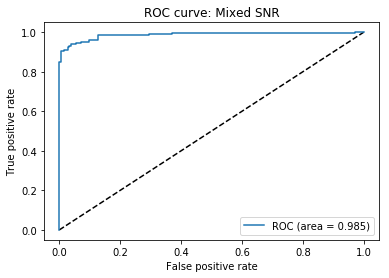

In [87]:
# Mixed SNRs: (-5, 0, 5, 10 dB SNR)

plotROC(False, 'ROC curve: Mixed SNR')

Uniform SNR with SNR =  -10
Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:00:21.725961


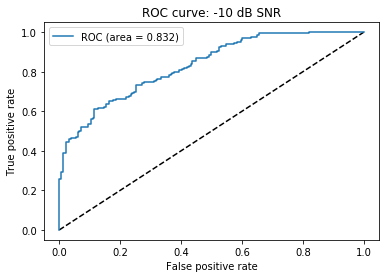

In [88]:
# SNR of -10 dB

plotROC(-10, 'ROC curve: -10 dB SNR')

Uniform SNR with SNR =  -5
Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:00:21.698075


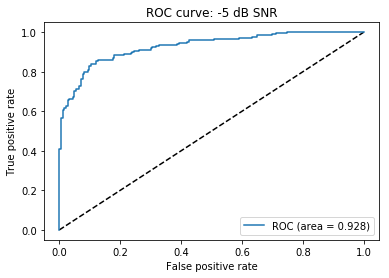

In [89]:
# SNR of -5 dB

plotROC(-5, 'ROC curve: -5 dB SNR')

SNR of 0 dB
Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:00:21.919018


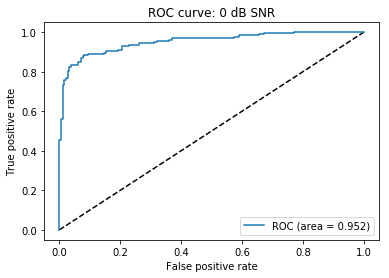

In [90]:
# SNR of 0 dB

plotROC(True, 'ROC curve: 0 dB SNR')

Uniform SNR with SNR =  5
Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:00:22.489311


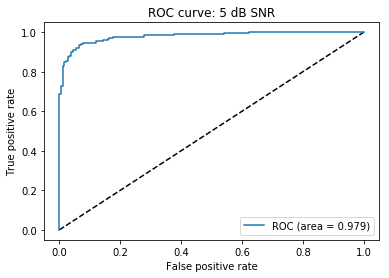

In [91]:
# SNR of 5 dB

plotROC(5, 'ROC curve: 5 dB SNR')

Uniform SNR with SNR =  10
Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:00:23.264401


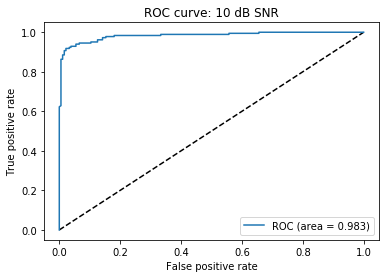

In [92]:
# SNR of 10 dB

plotROC(10, 'ROC curve: 10 dB SNR')

Uniform SNR with SNR =  15
Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:00:22.761185


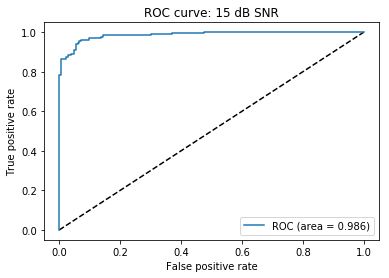

In [93]:
# SNR of 15 dB

plotROC(15, 'ROC curve: 15 dB SNR')

In [94]:
# SNR of 20 dB

plotROC(20)

TypeError: plotROC() missing 1 required positional argument: 'Title'

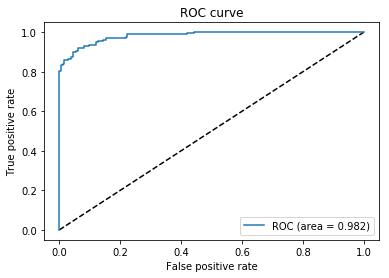

In [19]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ROC (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [21]:
# Compute ROC for various SNRs

num_samples = sirenNoiseVal.shape[0]

from sklearn.metrics import roc_curve
from numpy import ravel
from sklearn.metrics import auc
import matplotlib.pyplot as plt

num_rows = 40
num_columns = 130 #x_train.shape[2]
num_channels = 1

def getAUC(sirenSNR):

    num_samples = sirenNoiseVal.shape[0]
    X, yy = generateData(carNoiseVal, backNoiseVal, sirenNoiseVal, sirenSNR)

    X = X.reshape(X.shape[0], num_rows, num_columns, num_channels)

    y_pred_keras = model.predict_proba(X)
    predicted_proba = y_pred_keras[:,1]
    desc_score_indices = np.argsort(predicted_proba, kind="mergesort")[::-1]
    y_pred = predicted_proba

    y_test2 = yy[:,1]

    y_pred_keras = model.predict_proba(X)

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test2, y_pred)

    auc_keras = auc(fpr_keras, tpr_keras)
    
    print('AUC for SNR of ', sirenSNR, 'is ', auc_keras)

    return auc_keras

In [20]:
#SNRs = range(-20, 30)
#AUCs = np.empty(len(SNRs))
#for i in range(0, len(SNRs)):
#    AUCs[i] = SNRs[i]
    
#print(AUCs)
AUCs = getAUC(0)
print(AUCs)

SNR of 0 dB
Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:00:15.414706
0.9759622562632506


In [22]:
SNRs = range(-20, 30)
AUCs = np.empty(len(SNRs))
for i in range(0, len(SNRs)):
    AUCs[i] = getAUC(SNRs[i])

Uniform SNR with SNR =  -20
Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:00:15.366896
AUC for SNR of  -20 is  0.7723431574546866
Uniform SNR with SNR =  -19
Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:00:15.503924
AUC for SNR of  -19 is  0.7396458538624623
Uniform SNR with SNR =  -18
Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:00:22.376027
AUC for SNR of  -18 is  0.7070082713726895
Uniform SNR with SNR =  -17
Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:00:22.823460
AUC for SNR of  -17 is  0.7955746663083398
Uniform SNR with SNR =  -16
Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:00:20.530934
AUC for SNR of  -16 is  0.7985905819821434
Uniform SNR with SNR =  -15
Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:

Generating training and test data took:  0:00:17.210060
AUC for SNR of  27 is  0.9945653796769088
Uniform SNR with SNR =  28
Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:00:17.197408
AUC for SNR of  28 is  0.9934306787303293
Uniform SNR with SNR =  29
Finished scrambling data set
Extracting MFCCs...
Generating training and test data took:  0:00:16.977812
AUC for SNR of  29 is  0.9918779300665891


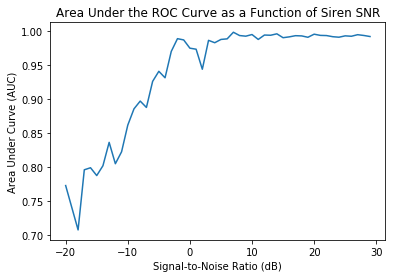

In [25]:
    # plot
    plt.figure(1)
    #plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(SNRs, AUCs)
    plt.xlabel('Signal-to-Noise Ratio (dB)')
    plt.ylabel('Area Under Curve (AUC)')
    plt.title('Area Under the ROC Curve as a Function of Siren SNR')
    #plt.legend(loc='best')
    plt.show()

In [19]:
sirenSet.shape
#sirenSet[:,:RATE*amountPlay].shapeS
list(range(10,20))

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [22]:
# Test various sounds

import sounddevice as sd
import time
startPlay = 0 # Where to start index
amountPlay = 5 # seconds
for i in list(range(startPlay, amountPlay+startPlay)):
    sd.play(sirenSet[i,:], RATE)
    time.sleep(3) 